# Lab | Matplotlib & Seaborn

#### Import all the necessary libraries here:

In [16]:
# Libraries
import numpy as np
import pandas as pd
import re
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

## Cleaning data

In [2]:
df = pd.read_csv(r'C:\Users\Tim_K\Ironhack\project-I-pandas\data\attacks.csv', encoding= 'unicode_escape')
df.sample()
all_columns = df.columns.values.tolist()
#Checking which columns we have in this dataframe
print(all_columns)

#There is 2 unnamed columns: 'Unnamed: 22' and 'Unnamed: 23', most entries in those column are nan so we drop those columns. 
df.drop(columns='Unnamed: 22', inplace=True)
df.drop(columns='Unnamed: 23', inplace=True)

['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href', 'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22', 'Unnamed: 23']


In [3]:
# There are a lot of NaN values, 17020 rows with only NaN values: we delete them all
df_nan = df[df.isnull().all(axis=1)]
df.dropna(how="all", inplace=True)

# There are still a lot of rows with mostly NaN values, we delete all rows that are for 75% or more NaN
perc = 75.0
min_count =  int(((100-perc)/100)*df.shape[1] + 1)
df.dropna(axis=0, thresh=min_count, inplace=True)

# We drop duplicates too
df.drop_duplicates()

# We rename this column so there is no blank space at the end
df.rename(columns={'Species ':'Species'}, inplace=True)
df.rename(columns={'Sex ':'Sex'}, inplace=True)

# There are a few columns that do not contain useful information, we drop them too
df.drop(columns='Case Number', inplace=True)
df.drop(columns='pdf', inplace=True)
df.drop(columns='href formula', inplace=True)
df.drop(columns='href', inplace=True)
df.drop(columns='Investigator or Source', inplace=True)
df.drop(columns='Case Number.1', inplace=True)
df.drop(columns='Case Number.2', inplace=True)
df.drop(columns='original order', inplace=True)




In [4]:
# There are a lot of different format entries in the column 'Date', we change them so they all have the same format, otherwise nan
df["Date"] = df["Date"].str.replace(r'^Reported\s', '', regex=True)
df["Date"] = df["Date"].str.replace(r'^[1-9]-', '0-', regex=True)
df["Date"] = df["Date"].str.replace(r'^\s', '', regex=True)
df["Date"] = df["Date"].str.replace(r'^Before\s', '', regex=True)
df['Date'] = df['Date'].apply(lambda x: re.sub(r'(^w{3,})\s', r'\1-', x))
df["Date"] = df["Date"].str.replace(r'^0-', '', regex=True)
df["Date"] = df["Date"].str.replace(r'^--', '-', regex=True)
df["Date"] = df["Date"].str.replace(r'^December ', 'Dec-', regex=True)
df["Date"] = df["Date"].str.replace(r'^November ', 'Nov-', regex=True)
df["Date"] = df["Date"].str.replace(r'^October ', 'Oct-', regex=True)
df["Date"] = df["Date"].str.replace(r'^September ', 'Sep-', regex=True)
df["Date"] = df["Date"].str.replace(r'^August ', 'Aug-', regex=True)
df["Date"] = df["Date"].str.replace(r'^July', 'Jul-', regex=True)
df["Date"] = df["Date"].str.replace(r'^June ', 'Jun-', regex=True)
df["Date"] = df["Date"].str.replace(r'^May ', 'May-', regex=True)
df["Date"] = df["Date"].str.replace(r'^March ', 'Mar-', regex=True)
df["Date"] = df["Date"].str.replace(r'^February ', 'Feb-', regex=True)
df["Date"] = df["Date"].str.replace(r'^January ', 'Jan-', regex=True)
df["Date"] = df["Date"].str.replace(r'^Mid', '15', regex=True)
df['Date'] = df['Date'].apply(lambda x: re.sub(r'(\w{3,})(\w{4})', r'\1-\2', x))
df['Date'] = df['Date'].apply(lambda x: re.sub(r'^(?=\d{2})\d*(?=\d{4}$)', '', x))
df['Date'] = df['Date'].apply(lambda x: x if re.match(r'^\d{2}-[a-zA-Z]{3}-\d{4}$', x) else np.nan)



In [5]:
# First we change everything in this column to numbers
df["Year"] = pd.to_numeric(df["Year"], errors='coerce')
# Changing all values that are lower than 1000 to nan
df["Year"] = df["Year"].apply(lambda x: np.nan if x < 1000 and not pd.isna(x) else x)
# Changing all floats to integers
df["Year"] = df["Year"].apply(lambda x: int(x) if isinstance(x, float) and not pd.isna(x) else x)
# Everything that isnt 4 characters to nan
df["Year"] = df["Year"].apply(lambda x: str(x)[:-2] if len(str(x)) > 4 and not pd.isna(x) else x)


In [6]:

df["Sex"] = df["Sex"].str.replace(r"\s$", '', regex=True)
valid_values_type = ['F', 'M']
df.loc[~df['Sex'].isin(valid_values_type), 'Sex'] = np.nan


In [7]:
# If entries in 'Type' are different than provoked or unprovoked, change to nan
valid_values_type = ['Provoked', 'Unprovoked']
df.loc[~df['Type'].isin(valid_values_type), 'Type'] = np.nan


In [8]:
# There are lots of entries with 'ocean' in the name, we change them to nan as that arent countries.
df.loc[df['Country'].str.contains('Ocean', case=False, na=False), 'Country'] = np.nan
# Also remove all white spaces at the beginning of entries 
df["Area"] = df["Area"].str.replace(r'^\s', '', regex=True)

# There are a lot of different names for more or less the same activies, with the dictionary below we make sure they fall into the same category.
activity_map = {
    'Kite surfing': 'Surfing',
    'Boogie boarding': 'Surfing',
    'Boogie Boarding': 'Surfing',
    'Windsurfing': 'Surfing',
    'Paddle-skiing': 'Paddling',
    'Body boarding': 'Surfing',
    'Stand-Up Paddleboarding': 'Surfing',
    'Wading': 'Fishing',
    'Kayak fishing for sharks': 'Fishing',
    'Spearfishing': 'Fishing',
    'Free diving': 'Diving',
    'Fishing / Wading': 'Fishing',
    'Scuba diving': 'Diving',
    'Scuba Dving': 'Diving',
    'Stand-Up Paddleboarding': 'Paddling',
    'Floating': 'Swimming',
    'Shark Fishing': 'Fishing',
    'Pearl diving': 'Diving',
    'Treading water': 'Swimming',
    'Body surfing': 'Surfing',
    'Fishing ': 'Fishing',
    'Shark fishing': 'Fishing',
    'Canoeing': 'Rowing',
    'Kayaking': 'Rowing',
    'Surf fishing': 'Fishing',
    'Surf-skiing': 'Surfing',
    'Surf skiing': 'Surfing',
    'Kayak Fishing': 'Fishing',
    'Fishing for sharks': 'Fishing',
    'Sponge diving': 'Diving',
    'Scuba Diving': 'Diving',
    'Freediving': 'Diving',
    'Sitting on surfboard': 'Surfing',
    'Diving for trochus': 'Diving',
    'Sailing' : 'Boating',
    'Paddle boarding' : 'Paddling',
    'Surf skiing' : 'Surfing',
    'Spearfishing' : 'Fishing',
    'Diving for abalone' : 'Diving',
    'Skindiving' : 'Diving',
    'Floating on his back' : 'Swimming',
    'Free diving for abalone' : 'Diving',
    'Surfing (sitting on his board)':'Surfing',
    'Kite Surfing':'Surfing',
    'Spearfishing on Scuba':'Fishing',
    'Fishing for mackerel':'Fishing',
    'Shipwreck':'Sea Disaster'
}
# Now we replace all this 'alternative descriptions' of the activities so they are the same
df['Activity'] = df['Activity'].replace(activity_map)
# We turn this dictionary values into a list
common_activities = (activity_map.values())


In [9]:
# First we change everything in this column to numbers
df["Age"] = pd.to_numeric(df["Age"], errors='coerce')
# Changing all values that are lower than 1000 to nan
df["Age"] = df["Age"].apply(lambda x: np.nan if x > 100 and not pd.isna(x) else x)
# Changing all floats to integers
df["Age"] = df["Age"].apply(lambda x: int(x) if isinstance(x, float) and not pd.isna(x) else x)
# Everything that isnt 4 characters to nan
df["Age"] = df["Age"].apply(lambda x: str(x)[:-2] if len(str(x)) > 2 and not pd.isna(x) else x)

In [10]:
#We change all entries to capital letters
df['Fatal (Y/N)'] = df['Fatal (Y/N)'].str.upper()
#Removing white spaces before
df["Fatal (Y/N)"] = df["Fatal (Y/N)"].str.replace(r'^\s', '', regex=True)
#Changing everything that isnt 'Y' 'N' or 'UNKNOWN' to nan
df['Fatal (Y/N)'] = df['Fatal (Y/N)'].where(df['Fatal (Y/N)'].isin(['Y', 'N', 'UNKNOWN']), np.nan)

In [11]:
#Removing white spaces at beginning
df["Time"] = df["Time"].str.replace(r'^\s', '', regex=True)
#Removing '-' symbols at beginning
df["Time"] = df["Time"].str.replace(r'-', '', regex=True)

#We change format of the entries so it meets the pattern
df["Time"] = df["Time"].str.replace(r'h', ':', regex=True)


#There are a lot of textual descritpions of time, to change them to numbers we have this dictionary below
time_map = {
    'Midday': '12:00',
    'Morning':'09:00',
    'Midnight':'00:00',
    'Evening':'20:00',
    'Early Afternoon':'13:00',
    'Just before noon': '11:00',
    'Early morning': '07:00',
    'Early Morning': '07:00',
    'A.M.' : '12:00',
    'AM' : '12:00',
    'Lunchtime':'13:00',
    'Afternoon':'15:00',
    'After noon':'15:00',
    'Evening':'21:00',
    'Late morning':'11:00',
    'Noon':'12:00',
    'Mid afternoon':'15:00',
    'Mid morning':'10:30',
    'Midmorning':'10:30',
    'After lunch':'15:00',
    'Midday':'12:00',
    'After midnight':'02:00',
    'Late afternon':'17:00',
    'Late Afternoon':'17:00',
    'Early evening':'19:00'
}
# Now we update those textual descriptions of time to numbers matching in the dictionary
df['Time'] = df['Time'].replace(time_map)

 
time_column = df['Time']
pattern = re.compile(r'^.*?(\d{2}:\d{2})')

for i, time in enumerate(time_column):
    if time and isinstance(time, str):
        match = re.search(pattern, time)
        if match:
            time_column.iloc[i] = match.group(1)

for i, time in enumerate(time_column):
    if time and isinstance(time, str):
        match = re.search(pattern, time)
        if not match:
            time_column.iloc[i] = np.nan


In [12]:
#In the Species column there are a lot of different ways refering to the same type, here we make sure that everything that contains 'tiger' will be 'Tiger shark' etc
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)tiger'), 'Species'] = 'Tiger shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)white'), 'Species'] = 'White shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)bull'), 'Species'] = 'Bull shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)tawny'), 'Species'] = 'Tawny nurse shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)lemon'), 'Species'] = 'Lemon shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)wobbegong'), 'Species'] = 'Wobbegong shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)spinner'), 'Species'] = 'Spinner shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)blacktip'), 'Species'] = 'Blacktip shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)blue'), 'Species'] = 'Blue shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)gill'), 'Species'] = 'Gill shark'
df.loc[df['Species'].notna() & df['Species'].str.contains('(?i)whale'), 'Species'] = 'Whale shark'

#List of the most common shark species 
common_sharks = ('Tiger shark', 'White shark', 'Bull shark', 'Tawny nurse shark', 
'Lemon shark', 'Wobbegong shark', 'Spinner shark', 'Blacktip shark', 'Blue shark', 'Gill shark', 'Whale shark')
 

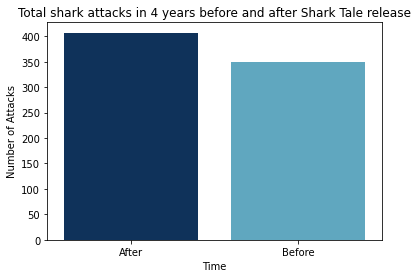

In [17]:


df['Date'] = pd.to_datetime(df['Date'])

df = df[(df['Date'] >= datetime(2000, 11, 1)) & (df['Date'] <= datetime(2008, 11, 1))]

df['Before/After'] = np.where(df['Date'] < datetime(2004, 11, 1), 'Before', 'After')

attacks_by_time = df.groupby(['Before/After']).size().reset_index(name='Count')

sns.barplot(x='Before/After', y='Count', data=attacks_by_time, palette=['#023167',"#50afcf"])
plt.xlabel('Time')
plt.ylabel('Number of Attacks')
plt.title('Total shark attacks in 4 years before and after Shark Tale release')
plt.show()

C:\Users\Tim_K\AppData\Local\Temp\ipykernel_9576\3801084930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_sharks['Before/After'] = np.where(df_white_sharks['Date'] < datetime(2004, 11, 1), 'Before', 'After')


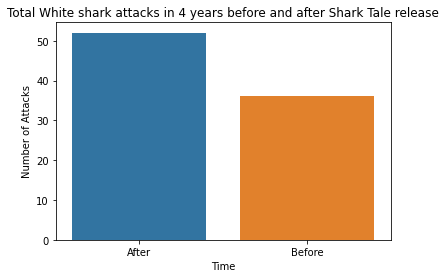

In [18]:
df_white_sharks = df[(df['Species'] == 'White shark') & (df['Date'] >= datetime(2000, 11, 1)) & (df['Date'] <= datetime(2008, 11, 1))]

df_white_sharks['Before/After'] = np.where(df_white_sharks['Date'] < datetime(2004, 11, 1), 'Before', 'After')

attacks_by_time = df_white_sharks.groupby(['Before/After']).size().reset_index(name='Count')

sns.barplot(x='Before/After', y='Count', data=attacks_by_time)
plt.xlabel('Time')
plt.ylabel('Number of Attacks')
plt.title('Total White shark attacks in 4 years before and after Shark Tale release')
plt.show()

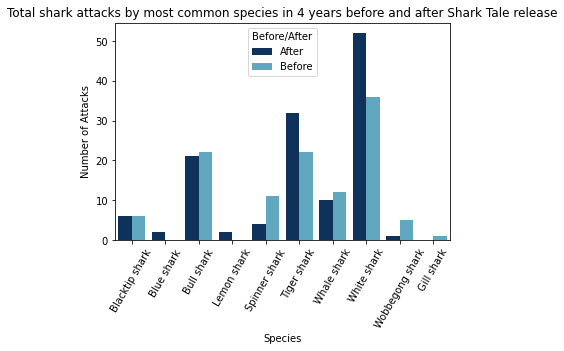

In [19]:
df['Date'] = pd.to_datetime(df['Date'])

common_sharks = ('Tiger shark', 'White shark', 'Bull shark', 'Tawny nurse shark', 
'Lemon shark', 'Wobbegong shark', 'Spinner shark', 'Blacktip shark', 'Blue shark', 'Gill shark', 'Whale shark')

df = df[df['Species'].isin(common_sharks) & (df['Date'] >= datetime(2000, 11, 1)) & (df['Date'] <= datetime(2008, 11, 1))]

df['Before/After'] = np.where(df['Date'] < datetime(2004, 11, 1), 'Before', 'After')

attacks_by_time = df.groupby(['Before/After', 'Species']).size().reset_index(name='Count')

sns.barplot(x='Species', y='Count', hue='Before/After', data=attacks_by_time, palette=['#023167',"#50afcf"])
plt.xlabel('Species')
plt.ylabel('Number of Attacks')
plt.title('Total shark attacks by most common species in 4 years before and after Shark Tale release')
plt.xticks(rotation=60)
plt.show()

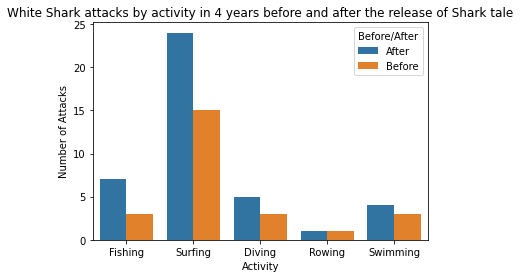

In [20]:
df_white_sharks = df[(df['Species'] == 'White shark') & (df['Activity'].isin(common_activities))]
df = df[(df['Date'] >= datetime(2000, 11, 1)) & (df['Date'] <= datetime(2008, 11, 1))]
df_white_sharks['Before/After'] = np.where(df_white_sharks['Date'] < datetime(2004, 11, 1), 'Before', 'After')

sns.countplot(x='Activity', hue='Before/After', data=df_white_sharks)
plt.xlabel('Activity')
plt.ylabel('Number of Attacks')
plt.title('White Shark attacks by activity in 4 years before and after the release of Shark tale')
plt.show()

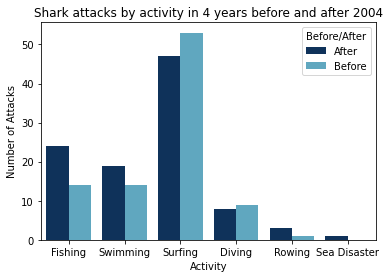

In [21]:
df_common_sharks = df[(df['Species'].isin(common_sharks)) & (df['Activity'].isin(common_activities))]
df = df_common_sharks[(df_common_sharks['Date'] >= datetime(2000, 11, 1)) & (df_common_sharks['Date'] <= datetime(2008, 11, 1))]
df_common_sharks['Before/After'] = np.where(df_common_sharks['Date'] < datetime(2004, 11, 1), 'Before', 'After')

sns.countplot(x='Activity', hue='Before/After', data=df_common_sharks, palette=['#023167',"#50afcf"])
plt.xlabel('Activity')
plt.ylabel('Number of Attacks')
plt.title('Shark attacks by activity in 4 years before and after 2004')
plt.show()

C:\Users\Tim_K\AppData\Local\Temp\ipykernel_9576\873470456.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month_Year'] = filtered_df['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))


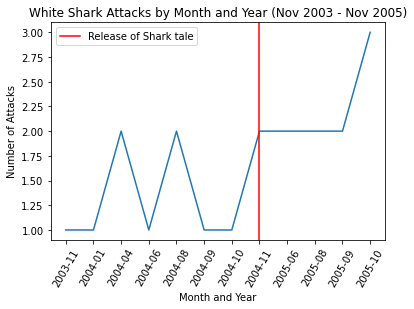

In [23]:
import datetime as dt 

filtered_df = df[(df['Species'] == 'White shark') & (df['Date'] >= '2003-11-01') & (df['Date'] <= '2005-11-01')]

filtered_df['Month_Year'] = filtered_df['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

grouped_df = filtered_df.groupby(['Month_Year']).size().reset_index(name='Count')

sns.lineplot(x='Month_Year', y='Count', data=grouped_df.sort_values(by='Month_Year'))
plt.xlabel('Month and Year')
plt.ylabel('Number of Attacks')
plt.title('White Shark Attacks by Month and Year (Nov 2003 - Nov 2005)')
plt.xticks(rotation=60)
plt.axvline('2004-11', color='red', label='Release of Shark tale')
plt.legend()
plt.show()

C:\Users\Tim_K\AppData\Local\Temp\ipykernel_1348\3109381499.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month_Year'] = filtered_df['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))


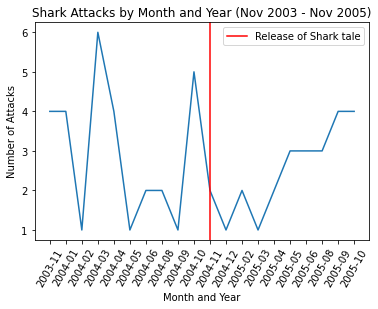

In [ ]:


filtered_df = df[(df['Species'].isin(common_sharks)) & (df['Date'] >= '2003-11-01') & (df['Date'] <= '2005-11-01')]

filtered_df['Month_Year'] = filtered_df['Date'].apply(lambda x: dt.datetime.strftime(x, '%Y-%m'))

grouped_df = filtered_df.groupby(['Month_Year']).size().reset_index(name='Count')


sns.lineplot(x='Month_Year', y='Count', data=grouped_df.sort_values(by='Month_Year'))
plt.xlabel('Month and Year')
plt.ylabel('Number of Attacks')
plt.title('Shark Attacks by Month and Year (Nov 2003 - Nov 2005)')
plt.xticks(rotation=60)
plt.axvline('2004-11', color='red', label='Release of Shark tale')
plt.legend()
plt.show()

C:\Users\Tim_K\AppData\Local\Temp\ipykernel_9576\4002219620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_sharks['Age'] = df_white_sharks['Age'].astype(float)
C:\Users\Tim_K\AppData\Local\Temp\ipykernel_9576\4002219620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_white_sharks['Age_group'] = pd.cut(df_white_sharks['Age'], range(15, 80, 5))


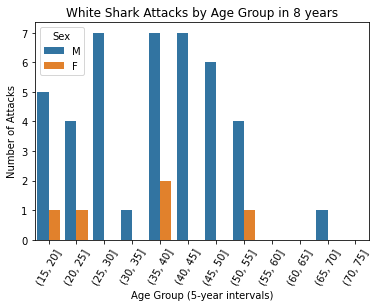

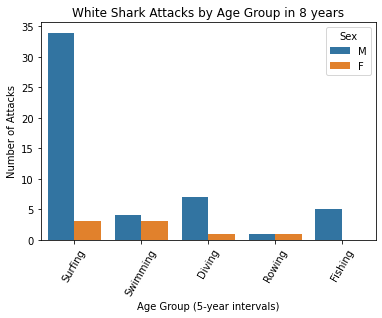

In [62]:
df_white_sharks = df[(df['Species'] == 'White shark') & (df['Activity'].isin(common_activities))]

df_white_sharks['Age'] = df_white_sharks['Age'].astype(float)
df_white_sharks['Age_group'] = pd.cut(df_white_sharks['Age'], range(15, 80, 5))
stack1 = sns.countplot(x='Age_group', hue='Sex', data=df_white_sharks.sort_values(by='Age'))
plt.xlabel('Age Group (5-year intervals)')
plt.xticks(rotation=60)
plt.ylabel('Number of Attacks')
plt.title('White Shark Attacks by Age Group in 8 years')
plt.show()

stack2 = sns.countplot(x='Activity', hue='Sex', data=df_white_sharks.sort_values(by='Age'))
plt.xlabel('Age Group (5-year intervals)')
plt.xticks(rotation=60)
plt.ylabel('Number of Attacks')
plt.title('White Shark Attacks by Age Group in 8 years')
plt.show()

